In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil



<h2><center><font color=#D40004><u>Twitter (X) Sentiment Analysis for Deep Learning  </u></font></center></h2>

<div style="padding: 40px; background: linear-gradient(135deg, #f5f7fa, #cdd2d8); border: 3px groove #d1d8e0; border-radius: 30px; box-shadow: 0 10px 25px rgba(0,0,0,0.1); font-size: 120%; line-height: 1.9; color: #333; font-family: 'Georgia', serif; text-align: justify; position: relative;">
    <h2 style="color: #2c3e50; font-size: 150%; border-bottom: 3px solid #3498db; display: inline-block; padding-bottom: 10px; margin-bottom: 20px;">
        Project Objective
    </h2>
   <p style="font-size: 100%; color: #34495e; letter-spacing: 1px;">In the digital realm, social media platforms stand as influential conduits for individuals to voice their opinions and sentiments. This project, titled Tweet Sentiment Analysis for Deep Learning, aims to harness the prowess of deep learning algorithms to comprehensively analyze and interpret the myriad of sentiments expressed across diverse social platforms. Employing cutting-edge natural language processing (NLP) techniques, this initiative aspires to furnish invaluable insights into prevailing public opinions, emotions, and emerging trends.</p>
</div>


# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:center; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'></span></b> <b>Table of Contents</b></div>

* [I. Loading and Importing Libraries](#1)
* [II. Loading and Preprocessing Datase](#2)
  * [1. Loading Dataset](#3)
  * [2. Check for Missing and Duplicate Values](#4)
  * [3. Preprocessing Text](#5)
* [III. Data Analysis](#6)
  * [1. Distribution of Sentiments](#7)
  * [2. Tweets length analysis](#8)
  * [3. Data Preprocessing](#9)
  * [4. Feature Extraction](#10)
  * [5. Tokenizing & Padding](#11)
* [IV. Build the model](#12)
  * [1. Bidirectional LSTM Using NN](#13)
      * [ Model Accuracy & Loss](#14)
      * [ Model Confusion Matrix](#15)
      * [Model save and load for the prediction](#16)
  * [2. BERT Classification](#17)
      * [ Train - Validation - Test split](#18)
      * [ BERT Tokenization](#19)
      * [ Data Loaders](#20)
      * [ BERT Modeling](#21)
      * [BERT Training](#22)
      * [BERT Prediction](#23)

<a id='1'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>I |</span></b> <b>Loading and Importing Libraries</b></div>

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn nltk keras torch gensim transformers emoji

In [ ]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from imblearn.over_sampling import RandomOverSampler
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses
# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

# Transformers library for BERT
import transformers as tf
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)
nltk.download('stopwords')

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

<ipython-input-7-99655a85382b>:67: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Figure size 640x480 with 0 Axes>

<a id='2'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>II |</span></b> <b>Loading and Preprocessing Datase</b></div>

<a id='3'></a>

>## Loading Dataset

In [ ]:
df = pd.read_csv('', encoding='ISO-8859-1')

In [ ]:
df.head(5)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


<a id='4'></a>

>## Check for Missing and Duplicate Values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [ ]:
df.isna().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

So we will remove the row with missing text

In [ ]:
df.dropna(inplace=True)

In [ ]:
# Verify Row Duplicates
df.duplicated().sum()

0

In [ ]:
df.drop(columns=['textID', 'selected_text', 'Time of Tweet',
       'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)',
       'Density (P/Km²)'], inplace=True)

<a id='5'></a>
>## Preprocessing Text

Tweets require lots of cleaning but it is inefficient to clean every single tweet because that would consume too much time. A general approach must be implemented for cleaning.

* The most common type of words that require cleaning in `oov` have punctuations at the start or end. Those words doesn't have embeddings because of the trailing punctuations. Punctuations `#`, `@`, `!`, `?`, `+`, `&`, `-`, `$`, `=`, `<`, `>`, `|`, `{`, `}`, `^`, `'`, `(`, `)`,`[`, `]`, `*`, `%`, `...`, `'`, `.`, `:`, `;` are separated from words
* Special characters that are attached to words are removed completely
* Contractions are expanded
* Urls are removed
* Character entity references are replaced with their actual symbols
* Typos and slang are corrected, and informal abbreviations are written in their long forms
* Some words are replaced with their acronyms and some words are grouped into one
* Finally, hashtags and usernames contain lots of information about the context but they are written without spaces in between words so they don't have embeddings. Informational usernames and hashtags should be expanded but there are too many of them. I expanded as many as I could, but it takes too much time to run `clean` function after adding those replace calls.

In [ ]:
def clean_text(text):
    # Convert text to lowercase for uniformity
    text = str(text).lower()

    # Remove numbers
    text = re.sub('\d+', '', text)

    # Remove HTML tags
    text = re.sub('\[.*?\]', '', text)

    # Remove URLs
    text = re.sub('https?://\S+|www\.\S+', '', text)

    # Remove emojis and other unicode symbols
    text = re.sub(r"["
                  u"\U0001F600-\U0001F64F"  # emoticons
                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                  u"\U00002702-\U000027B0"
                  u"\U000024C2-\U0001F251"
                  "]+", "", text)

    # Remove punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # Additional cleaning for specific words and characters
    text = re.sub(r'\band\b|\bin\b|\b...\b', '', text)

    # Remove specific quotation marks
    text = text.replace('“', '').replace('”', '')

    # Remove double quotes and excessive newlines
    text = text.replace('"', '').replace('\n\n', ' ')

    return text

In [ ]:
df['cleantext'] = df['text'].apply(clean_text)

In [ ]:
df.head(5)

,text,sentiment,cleantext
0,"I`d have responded, if I were going",neutral,have respondedwere going
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo will miss here diego
2,my boss is bullying me...,negative,boss bullying
3,what interview! leave me alone,negative,what interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,sons couldnt they them releases already b...


In [ ]:
# Example
print("Text before preprocessing:\n", df.loc[1, 'text'])
print("Text before preprocessing:\n", df.loc[1, 'cleantext'])

Text before preprocessing:
  Sooo SAD I will miss you here in San Diego!!!
Text before preprocessing:
  sooo will miss  here  diego


<a id='6'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>III |</span></b> <b>Data Analysis and Feature Extraction</b></div>

<a id='7'></a>
>## Distribution of Sentiments

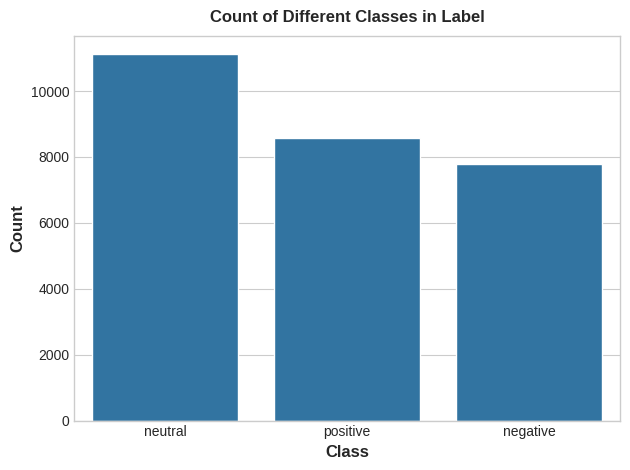

In [ ]:
class_counts = df['sentiment'].value_counts()

# Plotting the counts
sns.barplot(x=class_counts.index, y=class_counts.values)

# Adding title and labels
plt.title('Count of Different Classes in Label')
plt.xlabel('Class')
plt.ylabel('Count')

# Display the plot
plt.show()

<a id='8'></a>
>## Tweets length analysis

Now we will define a new dataframe column containing the length of the cleaned tweets in terms of number of words.

In [ ]:
df['text_len'] = [len(text.split()) for text in df.cleantext]

<ipython-input-21-2b24d6e4208d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[df['text_len'] < 10], palette='mako')


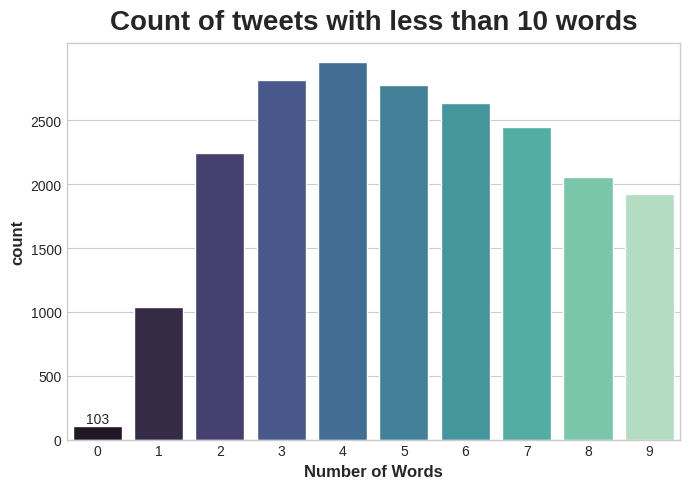

In [ ]:


# Setting up the plot
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='text_len', data=df[df['text_len'] < 10], palette='mako')

# Title and labels
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.ylabel('count')
plt.xlabel('Number of Words')

max_count = df['text_len'].value_counts().max()
plt.yticks(range(0, max_count+1, 500))

# Adding bar labels
ax.bar_label(ax.containers[0])

# Show the plot
plt.show()

**What about long tweets?**

<ipython-input-22-995735973d78>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df, palette='Blues_r')


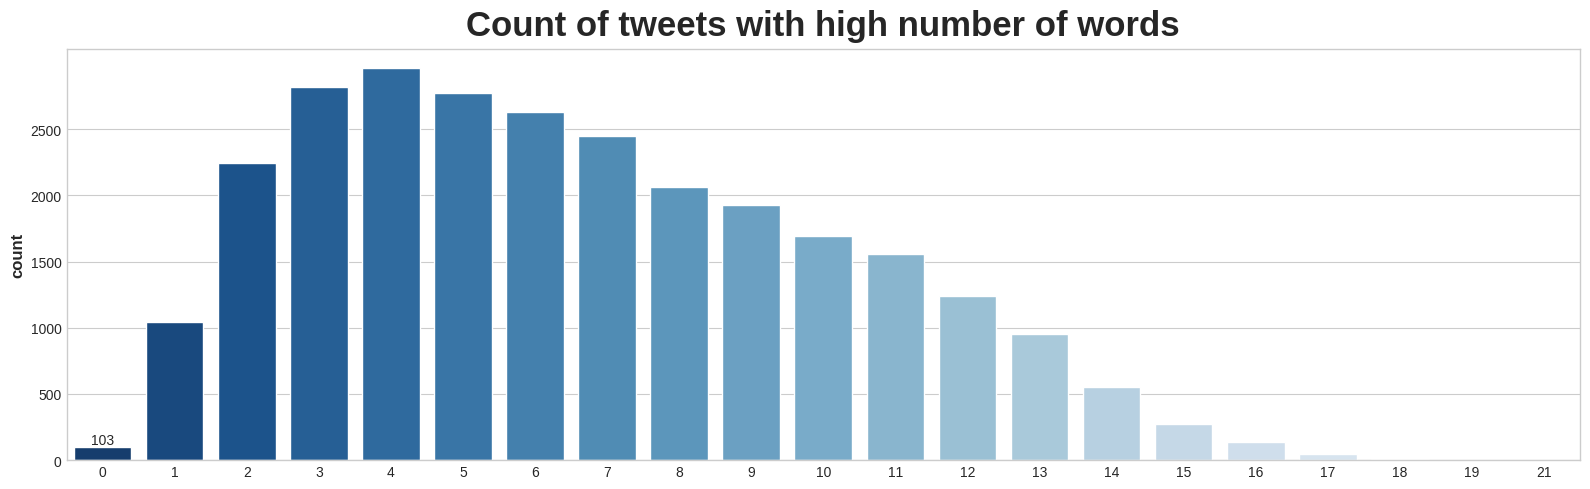

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df, palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
max_count = df['text_len'].value_counts().max()
plt.yticks(range(0, max_count+1, 500))
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

So, it seems that our dataset does not contain a large number of lengthy tweets. Therefore, we will be working with all the tweets available.

<a id='9'></a>
>## Data Preprocessing

In [ ]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''

    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['cleantext'][1])
print("\nProcessed tweet ->", tweet_to_words(df['cleantext'][1]))


Original tweet ->  sooo will miss  here  diego

Processed tweet -> ['sooo', 'miss', 'diego']


In [ ]:
# Apply data processing to each tweet
X = list(map(tweet_to_words, df['cleantext']))

In [ ]:
# Encode target labels
y = pd.get_dummies(df['sentiment'].map({'negative': -1.0, 'neutral': 0, 'positive': 1.0}))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

<a id='10'></a>
>## Feature Extraction

In [ ]:
vocabulary_size = 5000

# Tweets have already been preprocessed hence dummy function will be passed in
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x)
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<a id='11'></a>
>## Tokenizing & Padding

In [ ]:
max_words = 5000
max_len=50
def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['cleantext'][1])
X, tokenizer = tokenize_pad_sequences(df['cleantext'])
print('After Tokenization & Padding \n', X[1])

Before Tokenization & Padding 
  sooo will miss  here  diego
After Tokenization & Padding 
 [ 284   24   43   36 1845    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,stratify=y_train, test_size=0.1, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (22258, 50) (22258, 3)
Validation Set -> (2474, 50) (2474, 3)
Test Set -> (2748, 50) (2748, 3)



<a id='12'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>V |</span></b> <b>Build the model</b></div>

<a id='13'></a>
>## Bidirectional LSTM Using NN

In [ ]:
vocab_size = 5000
embedding_size = 32
epochs=25
learning_rate = 0.1
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size,input_shape=(max_len,)))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

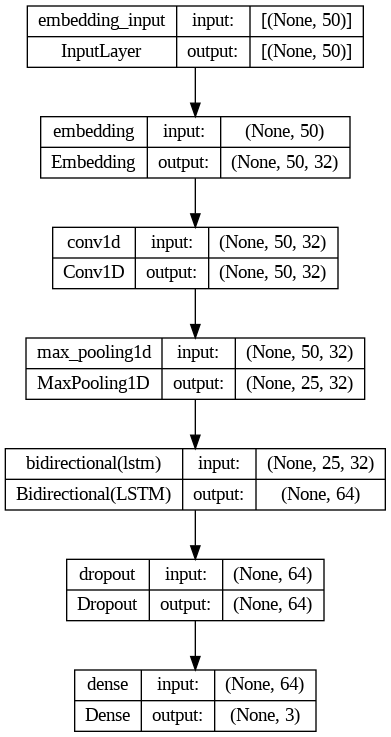

In [ ]:
import tensorflow as tf

# Now visualize the model
tf.keras.utils.plot_model(model, show_shapes=True)


In [ ]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd,
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=15, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            160000    
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 25, 32)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 1

<a id='14'></a>
>>### Model Accuracy & Loss

In [ ]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''

    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.5684
Precision : 0.6710
Recall    : 0.3191
F1 Score  : 0.4326


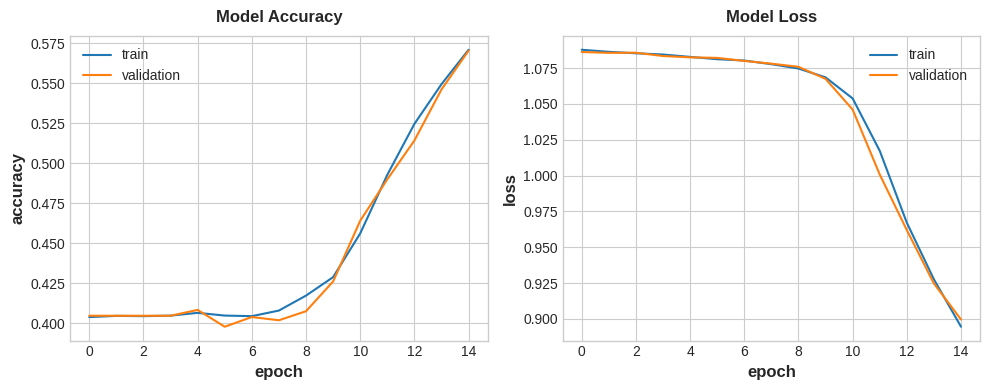

In [ ]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

<a id='15'></a>
>>### Model Confusion Matrix

86/86 [==============================] - 1s 3ms/step


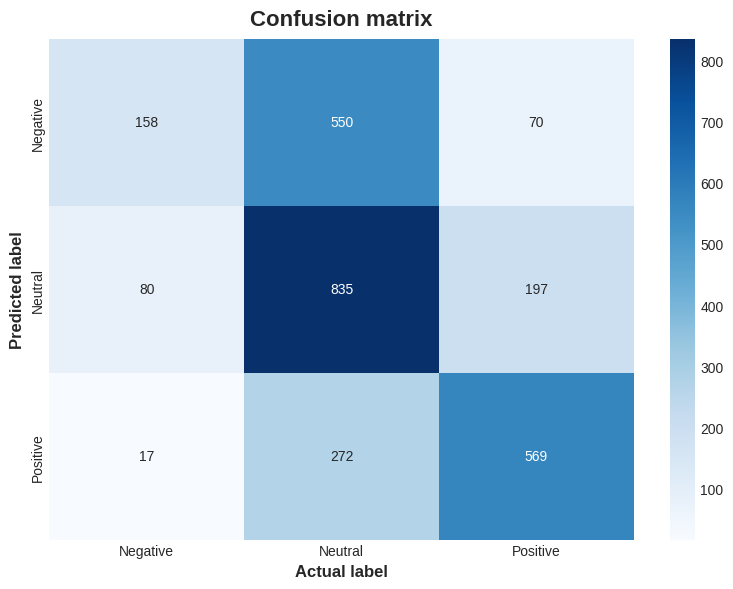

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model, X_test, y_test)


<a id='16'></a>
>>### Model save and load for the prediction

In [ ]:
# Save the model architecture & the weights
model.save('lstm_model.h5')
print('Best model saved')

Best model saved


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model

# Load model
model = load_model('lstm_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50

    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [ ]:
predict_class(['"I hate when I have to call and wake people up'])

1/1 [==============================] - 1s 705ms/step
The predicted sentiment is Negative


In [ ]:
predict_class(['The food was meh'])

1/1 [==============================] - 0s 21ms/step
The predicted sentiment is Neutral


In [ ]:
predict_class(['He is a best minister india ever had seen'])

1/1 [==============================] - 0s 20ms/step
The predicted sentiment is Positive


<a id='17'></a>
>## BERT Classification

In this section, we will load a pre trained BERT model from the Hugging Face library and fine tune it for our classification task.

<a id='18'></a>
>> ### Train - Validation - Test split

In [ ]:
X = df['cleantext'].values
y = df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2}).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=143)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=143)

<a id='19'></a>
>>### BERT Tokenization

Since we need to tokenize the tweets (get "input ids" and "attention masks") for BERT, we load the specific BERT tokenizer from the Hugging Face library.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Then we define a custom tokenizer function using the loaded tokenizer.

In [ ]:
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Since we need to specify the length of the longest tokenized sentence, we tokenize the train tweets using the "encode" method of the original BERT tokenizer and check the longest sentence.

In [ ]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  34


We can choose the max length as 34.

In [ ]:
MAX_LEN = 34

Then we can tokenize the train, validation and test tweets using the custom define tokenizer.

In [ ]:
train_inputs, train_masks = bert_tokenizer(X_train)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Since we are using the BERT model built on PyTorch, we need to convert the arrays to pytorch tensors and create dataloaders for the data.

In [ ]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train.astype(int))
val_labels = torch.from_numpy(y_valid.astype(int))
test_labels = torch.from_numpy(y_test.astype(int))

In [ ]:
train_labels

tensor([2, 2, 2,  ..., 1, 0, 2])

<a id='20'></a>
>>### Data Loaders

In [ ]:
batch_size = 32

In [ ]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

<a id='21'></a>
>>### BERT Modeling

Now we can create a custom BERT classifier class, including the original BERT model (made of transformer layers) and additional Dense layers to perform the desired classification task.

In [ ]:
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 3

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate the classifier (a fully connected layer followed by a ReLU activation and another fully connected layer)
        self.classifier = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )

        # Freeze the BERT model weights if freeze_bert is True (useful for feature extraction without fine-tuning)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input data (input_ids and attention_mask) to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the `[CLS]` token from the BERT output (useful for classification tasks)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed the extracted hidden state to the classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Moreover, since we want to define a learning rate scheduler, we define a custom "initalize_model" function as follows.

In [ ]:
# Function for initializing the BERT Classifier model, optimizer, and learning rate scheduler
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)

    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Define the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

We also specify the use of GPU if present (highly recommended for the fine tuning)

In [ ]:
device = 'cpu'
EPOCHS=2

And then we intialize the BERT model calling the "initialize_model" function we defined.

In [ ]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<a id='22'></a>
>>### BERT Training

After defining the custom BERT classifier model, we are ready to start the training.

In [ ]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1

            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###

        # Put the model into the evaluation mode
        model.eval()

        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)

            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)

        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")

    print("Training complete!")

In [ ]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=1)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.890141   |  128.00  
   200    |   0.744261   |  126.49  
   300    |   0.710626   |  125.40  
   400    |   0.708906   |  125.92  
   500    |   0.694347   |  126.27  
   600    |   0.660322   |  125.64  
   695    |   0.682188   |  119.16  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.727814    |  0.694829  |       72.48       |  903.78  
-------------------------------------------------------------


Training complete!


<a id='23'></a>
>> ### BERT Prediction

Now we define a function similar to the model "evaluation", where we feed to the model the test data instead of the validation data.

In [ ]:
def bert_predict(model, test_dataloader):

    # Define empty list to host the predictions
    preds_list = []

    # Put the model into evaluation mode
    model.eval()

    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]

        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)

        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

Then we can call the defined function and get the class predictions of the test data.

In [ ]:
bert_preds = bert_predict(bert_classifier, test_dataloader)
sentiments = ['negative', 'neutral', 'positive']
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=sentiments))

Classification Report for BERT :
               precision    recall  f1-score   support

    negative       0.75      0.65      0.70       778
     neutral       0.70      0.69      0.70      1112
    positive       0.72      0.82      0.77       858

    accuracy                           0.72      2748
   macro avg       0.72      0.72      0.72      2748
weighted avg       0.72      0.72      0.72      2748



In [ ]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(12,12))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16)
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

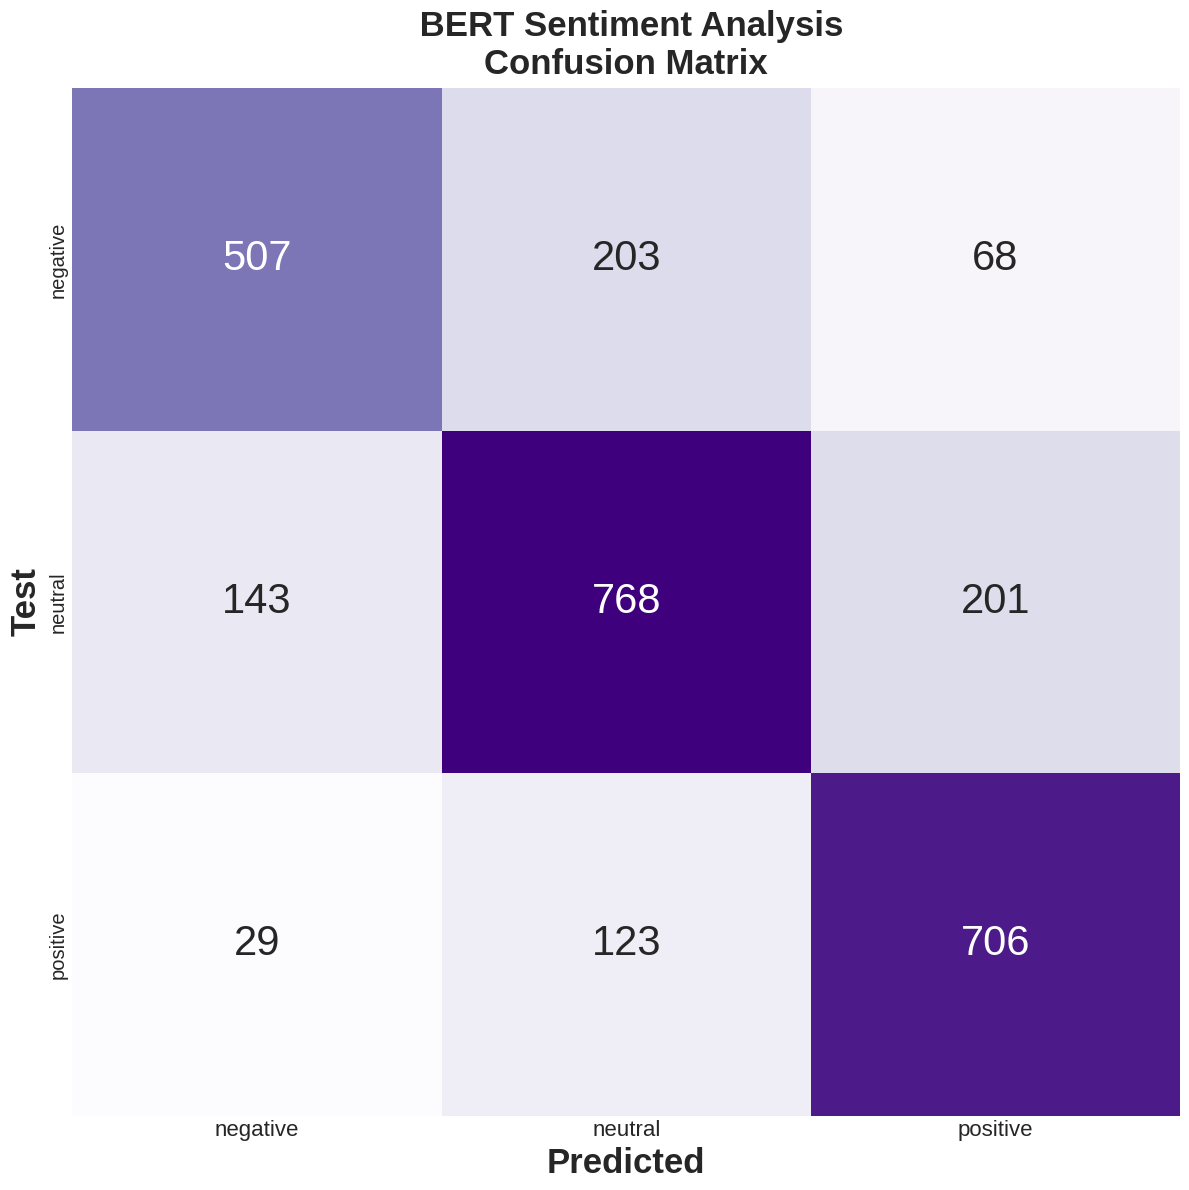

In [ ]:
conf_matrix(y_test, bert_preds,' BERT Sentiment Analysis\nConfusion Matrix', sentiments)

**The performance scores of BERT Classifier are quite high and higher than those achieved using the LSTM model, with an overall accuracy around 72% and F1 scores well over 70%.**<br>